In [47]:
#FILE PREPROCESSING DATASET TEMPO
from zipfile import ZipFile
import xml.etree.cElementTree as et
from os import listdir,mkdir,system
from os.path import isfile, join, splitext,exists
from scipy.io import wavfile
from scipy import signal
import sys
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from madmom.audio.filters import MelFilterbank 
from pydub import AudioSegment
import os
import soundfile as sf

def unzip(path):
    
    for p in path:
        with ZipFile(p, 'r') as zipp:
            print('Extracting all the files now...')
            zipp.extractall()
            print('Done!')
        

def ext_ann(path_ann):
    tree=et.parse('extendedballroom_v1.1.xml')
    root=tree.getroot()
    for n in range(len(root)):
        for x in root[n]:
            a=open(f"{path_ann}/{x.attrib['id']}.txt",'w')
            a.write(str(x.attrib['bpm']))
            a.close()

def get_data_ext():
    os.rename("getExtendedBallRoomDataset.py", "Dataset/Ext_tempo/getExtendedBallRoomDataset.py")
    os.system('python getExtendedBallRoomDataset.py')
    
def rename_file(path):
    #I delete the key file for faster stuff
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    for f in onlyfiles:
        os.rename(f"{path}/{f}",f"{path}/{splitext(f)[0]}.txt")
        
        
def convert_to_wav(path):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    
    #let's first create the directory for wav
    
    #for each file, convert it into wav
    for f in onlyfiles:
        sound = AudioSegment.from_mp3(f"{path}/{f}")
        dst = f"{path}/{splitext(f)[0]}.wav"
        sound.export(dst, format="wav")
        os.remove(f"{path}/{f}")
        

path_giant_ann="Dataset/Tempo/GS/Ann"
path_giant_audio="Dataset/Tempo/GS/Audio"
path_giant_image="Dataset/Tempo/GS/Image_spec"
path_ext_ann="Dataset/Tempo/EXT/Ann"
path_ext_audio="Dataset/Tempo/EXT/Audio"
path_ext_image="Dataset/Tempo/EXT/Image_spec"

In [ ]:
path=['Dataset/Tempo/gs_tempo.zip','Dataset/Tempo/Ext_tempo.zip']
unzip(path)

In [42]:
ext_ann(path_ext_ann)

In [16]:
convert_to_wav(path_ext_audio)
convert_to_wav(path_giant_audio)

In [27]:
#It is preferable to have everything standardized, even the extension of the annotation
rename_file(path_giant_ann)

In [44]:
def augmentation_data(path_audio,path_ann):
    #1st data augmentation, using librosa let's accelerate/decelerate the speed, consequently the bpm
    #by shifting to right and left 1/5 the original speed
    onlyfiles = [f for f in listdir(path_audio) if isfile(join(path_audio, f))]
    for f in onlyfiles:
        a=open(f"{path_ann}/{splitext(f)[0]}.txt","r")
        bpm=a.readlines()
        a.close()
        y,sr=librosa.load(f"{path_audio}/{f}")
        y_s = librosa.effects.time_stretch(y, 1.2)
        y_f =librosa.effects.time_stretch(y, 0.8)
        sf.write(f'{path_audio}/f_{f}', y_f, sr,'PCM_24')
        sf.write(f'{path_audio}/s_{f}', y_s, sr,'PCM_24')
        a=open(f"{path_ann}/f_{splitext(f)[0]}.txt","w")
        a.write(str(float(bpm[0])*2))
        a.close()
        a=open(f"{path_ann}/s_{splitext(f)[0]}.txt","w")
        a.write(str(float(bpm[0])/2))
        a.close()
    #2nd augmentation: cut the long audio into many pieces of audio
    #it is needed just 15 sec of audio 
    #in this way we standardize all the audio in the time frame (15 sec)
    onlyfiles = [f for f in listdir(path_audio) if isfile(join(path_audio, f))]
    for f in onlyfiles:
        y,sr=librosa.load(f"{path_audio}/{f}")
        if len(y)>sr*15:
            count=1
            
            #memorize the chord
            a=open(f"{path_ann}/{splitext(f)[0]}.txt","r")
            bpm=a.readlines()
            a.close()
            
            while True:
                if(sr*15*count<=len(y)):
                    
                    y_new=y[sr*15*(count-1):sr*15*count]
                    sf.write(f'{path_audio}/{splitext(f)[0]}_{count}.wav', y_new, sr,'PCM_24')
                    if count==1: #rename the original file
                        os.rename(f"{path_ann}/{splitext(f)[0]}.txt", f"{path_ann}/{splitext(f)[0]}_{count}.txt")
                    else:
                        a=open(f"{path_ann}/{splitext(f)[0]}_{count}.txt","w")
                        a.write(str(bpm[0]))
                        a.close()
                    count+=1
                else:
                    break
                    
                    
            os.remove(f"{path_audio}/{f}")
            
    
augmentation_data(path_giant_audio,path_giant_ann)
augmentation_data(path_ext_audio,path_ext_ann)

KeyboardInterrupt: 

<ipython-input-50-577db81ebba6>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


KeyboardInterrupt: 

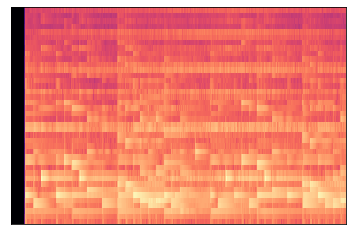

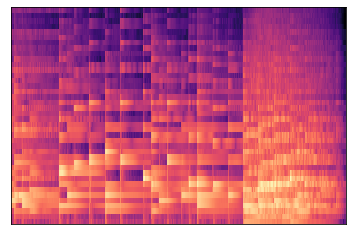

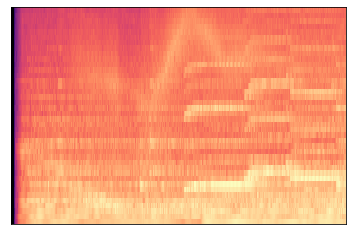

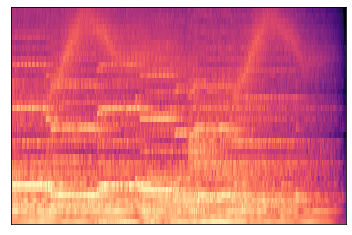

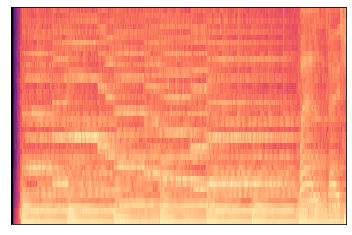

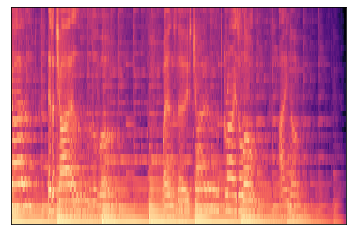

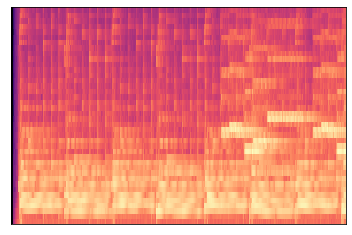

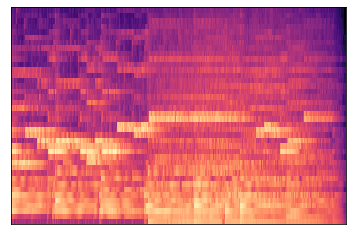

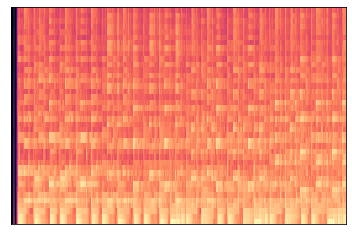

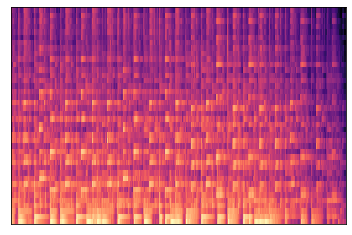

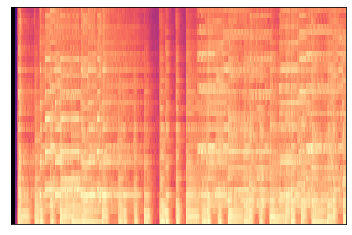

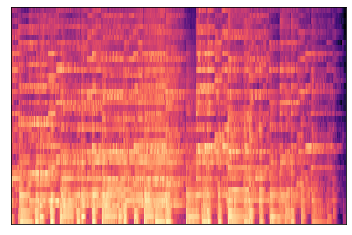

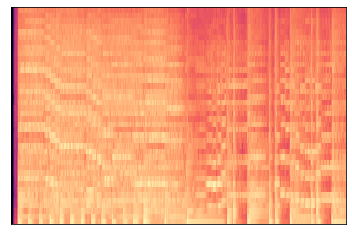

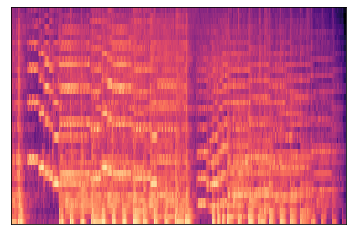

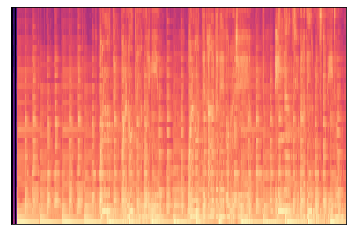

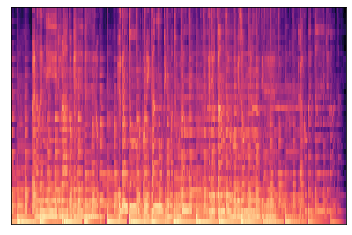

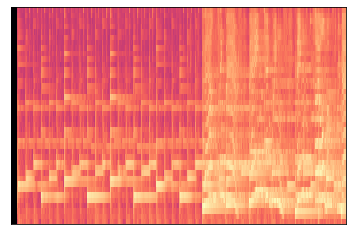

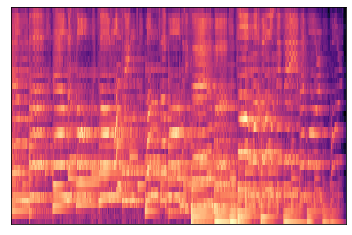

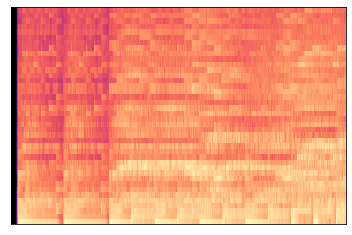

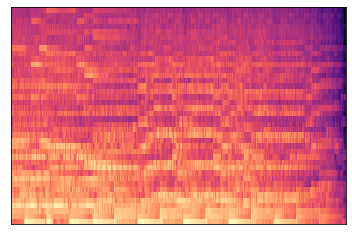

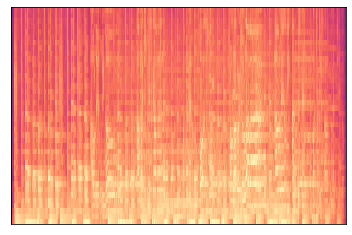

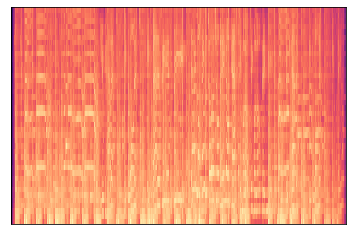

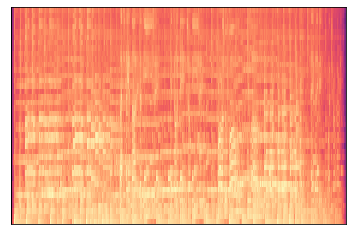

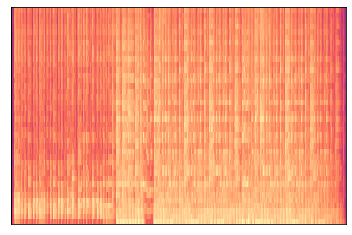

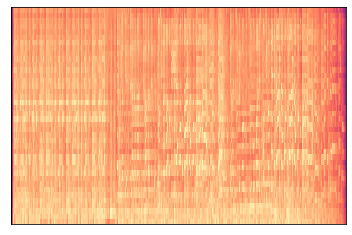

In [50]:
def create_image_spec(path_audio,path_img):
    #A good representation for the audio is in its mel-spectrogram form
    #It is decided to compute the log_mel_spectrgram of each audio 
    onlyfiles = [f for f in listdir(path_audio) if isfile(join(path_audio, f))]
    for f in onlyfiles:
        join(path,"wav")
        if not exists(f"{path_img}/{splitext(f)[0]}.jpeg"):
            y,sr=librosa.load(f"{path_audio}/{f}",sr=22050)
            ps = librosa.feature.melspectrogram(y=y,n_fft=1024, hop_length=1024//2,sr=sr,power=1,n_mels=40, fmin=20, fmax=5000)
            mels = np.log(ps + 1e-9)
            mels = librosa.power_to_db(ps, ref=np.max)
            fig, ax = plt.subplots()
            img = librosa.display.specshow(mels, sr=11025)
            plt.savefig(f"{path_img}/{splitext(f)[0]}.jpeg")
            
create_image_spec(path_giant_audio,path_giant_image)
create_image_spec(path_ext_audio,path_ext_image)